In [1]:
%matplotlib inline 
%load_ext autoreload 
%autoreload 2

# A comment

from __future__ import (print_function, division, absolute_import)

import os
import glob
import copy
import sys
import warnings

import numpy as np
np.set_printoptions(threshold='nan')

# Matplotlib related
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cmaps
plt.rc('text', usetex=False)

from astropy.table import \
    Table, \
    Column, \
    vstack, \
    hstack, \
    unique
    
from astropy.utils.metadata import MergeConflictWarning
warnings.filterwarnings('ignore', category=MergeConflictWarning, 
                        append=True)
from astropy import units as u
from astropy.coordinates import SkyCoord as sc
from astropy.utils.console import ProgressBar
from astropy import visualization as vs
from astropy.io import fits

import statistics as stat


plt.rcParams['figure.figsize'] = (12, 7)

In [2]:
table_hsc = Table.read('hsc_s16a_fastlane_g09_short_full.fits', format = 'fits')
table_decals = Table.read ('decals_dr3_g09_short.fits', format = 'fits')

table_hsc.sort('rcmodel_mag')
table_decals.sort('rmag_decal')

ra_hsc = table_hsc['ra']
dec_hsc = table_hsc['dec']
ra_decals = table_decals['RA']
dec_decals = table_decals['DEC']


In [3]:
"""
Absolute magnitude of the Sun in HSC filters
Right now, just use the DES filters
"""
SUN_G = 5.08
SUN_R = 4.62
SUN_I = 4.52
SUN_Z = 4.52
SUN_Y = 4.51

from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import Distance

# Setup the default cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

def luminosity2mag(luminosity, redshift, absmag_sun):
    """
    Convert the luminosity back to absolute magnitude: 
        absmag = absmag_sun - (2.5 * luminosity)
    
    Use redshift to estimate the distance modulus under 
    assumed cosmology.
    More on this topic please read: https://en.wikipedia.org/wiki/Distance_modulus
    
    Here we use the FlatLambdaCDM cosmology, assuming 
        Hubble constant: H0 = 70 km/s/Mpc; 
        Mass density parameter: Omega_m = 0.3
    
    Then convert the absolute magnitude back to apparent
    magnitude:
        mag = absmag + distmod 
    """
    
    # Convert luminosity into absolute magnitude with the 
    # help of the absolute magnitude of Sun in this filter
    absmag = absmag_sun - (2.5 * luminosity) 
    
    # Estimate the distance modulus given redshift 
    # and convert the absolute magnitude back to apparent one
    return (absmag + 
            Distance(z=redshift, cosmology=cosmo).distmod.value)
    
"""
The luminosity2mag() function should work with array
So using the current table, you should be able to convert 
the luminosity within 100 kpc: `lum_100` into magnitude using
"""
mag_i_100kpc = luminosity2mag(table_hsc['lum_100'], 
                              table_hsc['z_best'], 
                              SUN_I)

"""
This magnitude has been corrected for Galactic extinction.
You do not need to do that again. 

We should have used mag_r_100, but since we do not have them 
right now, let's use the CModel (r-i) color to convert the 
i-band magnitude into r-band magnitude first. 

Color here describes the magnitude difference between two filters: 
    (g-i)_cmodel = gcmodel_mag - icmodel_mag

For massive galaxies in this sample, their spectral energy
distributions (SED) are quite similar, and using a simple 
color conversion is not a terrible idea.  
""" 

# Get the r-i color using CModel photometry 
ri_cmodel = ((table_hsc['rcmodel_mag'] - table_hsc['a_r']) - 
             (table_hsc['icmodel_mag'] - table_hsc['a_i']))

# Convert the i-band 100 kpc magnitude into r-band assuming
# the same (r-i) colors. 
mag_r_100kpc = mag_i_100kpc + ri_cmodel
    
table_hsc.add_column(mag_r_100kpc, name='mag_r_100kpc')
# Then you can use this magnitude for comparison.

In [4]:
hsc = sc(ra=ra_hsc*u.degree, dec=dec_hsc*u.degree)  
decals = sc(ra=ra_decals*u.degree, dec=dec_decals*u.degree)  
idx, d2d, d3d = hsc.match_to_catalog_sky(decals)

Now idx are indices into decals catalog that are the closest objects to each of the coordinates in hsc catalog, d2d are the on-sky distances between them, and d3d are the 3-dimensional distances. 

now we get arrays of the luminosities and plot them

In [5]:
#d2d  cut
idx_use = np.asarray(d2d.to(u.arcsec))<=3.0

In [6]:
#merge catalogs and apply d2d cut
table_merge = hstack([table_hsc, table_decals[idx]])
table_use = table_merge[idx_use]

In [7]:
#split into four redshift bins
hsc_z = table_use['z_best']
#.25-.325, .325-.4, .4-.475, .475-.55
idx_1 = (hsc_z < .325)
idx_2 = (hsc_z > .325) & (hsc_z<.4)
idx_3 = (hsc_z > .4) & (hsc_z<.475)
idx_4 = (hsc_z > .475)

# R Band

In [8]:
#get columns into useful arrays, accounting for error
r_hsc = table_use['mag_r_100kpc']
r_decal = table_use['rmag_decal'] - table_use['a_r_decal']
#get magnitude differences and stellar masses
r_diff = r_hsc - r_decal 
lambda_redm = table_use['lambda_redm']
BCG = [x>0 for x in lambda_redm]

In [82]:
#label arrays
xx = r_hsc
yy = r_diff
cc = BCG
zz = hsc_z

idx_finite = ((np.isfinite(xx)) & np.isfinite(yy) & np.isfinite(zz))

xx_use = xx[idx_finite]
yy_use = yy[idx_finite]
zz_use = zz[idx_finite]

idx_1 = (zz_use < .325)
idx_2 = ((zz_use > .325) & (zz_use < .400))
idx_3 = ((zz_use > .400) & (zz_use < .475))
idx_4 = (zz_use > 0.475)

cc_use = [cc[i] for i in range(len(cc)) if (idx_finite[i])]
c_1 = [cc_use[i] for i in range(len(cc_use)) if (zz_use[i]<.325)]
c_2 = [cc_use[i] for i in range(len(cc_use)) if ((zz_use[i]>.325) & (zz_use[i]<.400))]
c_3 = [cc_use[i] for i in range(len(cc_use)) if ((zz_use[i] > .400) & (zz_use[i] < .475))]
c_4 = [cc_use[i] for i in range(len(cc_use)) if (zz_use[i] > 0.475)]

/Users/danecross/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/danecross/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/danecross/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:583: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


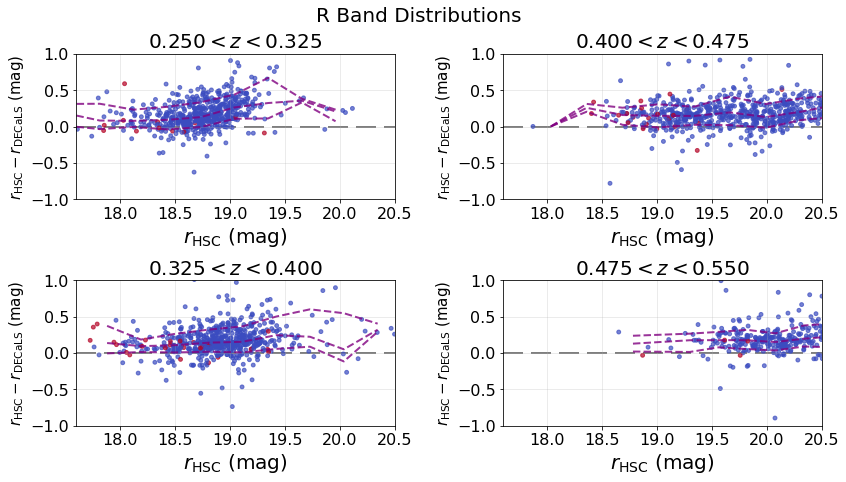

In [130]:
fig, axarr = plt.subplots(2, 2)
#fig.subplots_adjust(hspace=0.5)

c = 'purple'
c_k = cmaps.coolwarm

total_bins = 10

bins = np.linspace(xx_use[idx_1].min(), xx_use[idx_1].max(), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(xx_use[idx_1], bins)
running_median = [np.median(yy_use[idx_1][idx==k]) for k in range(total_bins)]
running_sixteen = [np.percentile(yy_use[idx_1][idx==k], 16) for k in range(1,total_bins)]
running_eighty_four = [np.percentile(yy_use[idx_1][idx==k], 84) for k in range(1,total_bins)]

axarr[0,0].scatter(xx_use[idx_1], yy_use[idx_1],
                   c=c_1,#cc_use[idx_1],
                   label='_nolegend_',
                   cmap=c_k, 
                   alpha=0.7, s=15)
axarr[0,0].set_title(r'$0.250 < z < 0.325$', 
                     fontsize=20)
axarr[0,0].plot(bins-delta/2,running_median,'--',c=c,linewidth=2.0,lw=4,alpha=.8)
axarr[0,0].plot(bins[1:total_bins]-delta/2 ,running_sixteen,'--',c=c,linewidth=2.0,lw=4,alpha=.8)
axarr[0,0].plot(bins[1:total_bins]-delta/2 ,running_eighty_four,'--',c=c,linewidth=2.0,lw=4,alpha=.8)


bins = np.linspace(xx_use[idx_2].min(), xx_use[idx_2].max(), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(xx_use[idx_2], bins)
running_median = [np.median(yy_use[idx_2][idx==k]) for k in range(total_bins)]
running_sixteen = [np.percentile(yy_use[idx_2][idx==k], 16) for k in range(1,total_bins)]
running_eighty_four = [np.percentile(yy_use[idx_2][idx==k], 84) for k in range(1,total_bins)]

axarr[1,0].scatter(xx_use[idx_2], yy_use[idx_2],
                   c=c_2,#cc_use[idx_2],
                   label='_nolegend_',
                   cmap=c_k, 
                   alpha=0.7, s=15)
axarr[1,0].set_title(r'$0.325 < z < 0.400$', 
                     fontsize=20)
axarr[1,0].plot(bins-delta/2 ,running_median,'--',c=c,linewidth=2.0,lw=4,alpha=.8)
axarr[1,0].plot(bins[1:total_bins]-delta/2 ,running_sixteen,'--',c=c,linewidth=2.0,lw=4,alpha=.8)
axarr[1,0].plot(bins[1:total_bins]-delta/2 ,running_eighty_four,'--',c=c,linewidth=2.0,lw=4,alpha=.8)


bins = np.linspace(xx_use[idx_3].min(), xx_use[idx_3].max(), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(xx_use[idx_3], bins)
running_median = [np.median(yy_use[idx_3][idx==k]) for k in range(total_bins)]
running_sixteen = [np.percentile(yy_use[idx_3][idx==k], 16) for k in range(1,total_bins)]
running_eighty_four = [np.percentile(yy_use[idx_3][idx==k], 84) for k in range(1,total_bins)]

axarr[0,1].scatter(xx_use[idx_3], yy_use[idx_3],
                   c=c_3, #cc_use[idx_3],
                   label='_nolegend_',
                   cmap=c_k, 
                   alpha=0.7, s=15)
axarr[0,1].set_title(r'$0.400 < z < 0.475$', 
                     fontsize=20)
axarr[0,1].plot(bins-delta/2,running_median,'--',c=c,linewidth=2.0,lw=4,alpha=.8)
axarr[0,1].plot(bins[1:total_bins]-delta/2 ,running_sixteen,'--',c=c,linewidth=2.0,lw=4,alpha=.8)
axarr[0,1].plot(bins[1:total_bins]-delta/2 ,running_eighty_four,'--',c=c,linewidth=2.0,lw=4,alpha=.8)


bins = np.linspace(xx_use[idx_4].min(), xx_use[idx_4].max(), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(xx_use[idx_4], bins)
#bin 2 is empty
running_median = [np.median(yy_use[idx_4][idx==k]) for k in range(1,total_bins) if (k!=2)]
xx_binned = [bins[k]-delta/2 for k in range(1,total_bins) if k!=2]
running_sixteen = [np.percentile(yy_use[idx_4][idx==k], 16) for k in range(1,total_bins) if (k!=2)]
running_eighty_four = [np.percentile(yy_use[idx_4][idx==k], 84) for k in range(1,total_bins) if (k!= 2)]


sc = axarr[1,1].scatter(xx_use[idx_4], yy_use[idx_4],
                   c=c_4,
                   #c=cc_use[idx_4],
                   label='_nolegend_',
                   cmap=c_k, 
                   alpha=0.7, s=15)
axarr[1,1].set_title(r'$0.475 < z < 0.550$', 
                     fontsize=20)
axarr[1,1].plot(xx_binned,running_median,'--',c=c,linewidth=2.0,lw=4,alpha=.8)
axarr[1,1].plot(xx_binned,running_sixteen,'--',c=c,linewidth=2.0,lw=4,alpha=.8)
axarr[1,1].plot(xx_binned,running_eighty_four,'--',c=c,linewidth=2.0,lw=4,alpha=.8)


#plt.scatter(xx_use,yy_use,color='k',alpha=.2,s=2)


for (m,n), subplot in np.ndenumerate(axarr):
    subplot.set_xlim(17.6, 20.5)
    subplot.set_ylim(-1, 1)
    
    # zorder=0 puts the grid in the background
    subplot.grid(alpha=0.3, zorder=0)
    
    subplot.set_xlabel(r'$r_{\rm HSC}\ ({\rm mag})$', fontsize=20)
    subplot.set_ylabel(r'$r_{\rm HSC}-r_{\rm DECaLS}\ ({\rm mag})$', 
                       fontsize=15)
    
    subplot.axhline(0.0, linewidth=2.0, alpha=0.5, c='k', 
                    zorder=0, linestyle='--', dashes=(10, 4))
    
    for tick in subplot.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in subplot.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    
plt.suptitle('R Band Distributions\n', fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

#cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
#cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmaps.magma, ticks=[0,1])
#cbar.set_label("Stellar Masses (Solar Masses)", fontsize=15)
#cbar.set_ticklabels([str(12), str(11)])

In [ ]:
#put outliers RA and DEC into txt files
percentile_abs = np.nanpercentile(abs(yy_use), 90)

idx_b = [((abs(x)>percentile_abs) & (x>0)) for x in r_diff]
idx_d = [((abs(x)>percentile_abs) & (x<0)) for x in r_diff]

r_b = table_use['ra', 'dec', 'object_id'][idx_b]
tbhdu = fits.BinTableHDU.from_columns(
     [fits.Column(name='ra', format='xxx', array=np.array(r_b['ra'])),
      fits.Column(name='dec', format='xxx', array=np.array(r_b['dec'])),
      fits.Column(name='object_id', format = 'E', array=np.array(r_b['object_id']))])
#tbhdu.writeto('r_b.fits')


r_d = table_use['ra', 'dec', 'object_id'][idx_d]
tbhdu = fits.BinTableHDU.from_columns(
     [fits.Column(name='ra', format='xxx', array=np.array(r_d['ra'])),
      fits.Column(name='dec', format='xxx', array=np.array(r_d['dec'])),
     fits.Column(name='object_id', format = 'E', array=np.array(r_d['object_id']))])
#tbhdu.writeto('r_d.fits')


# G Band

In [ ]:
#get columns into useful arrays, accounting for error
g_hsc = table_use['gcmodel_mag'] - table_use['a_g']
g_decal = table_use['gmag_decal'] - table_use['a_g_decal']
#get magnitude differences and stellar masses
g_diff = g_hsc - g_decal
mass = table_use['logm_100']

In [ ]:
#copy arrays for altering
xx = g_hsc
yy = g_diff
cc = mass
zz = hsc_z

idx_finite = ((np.isfinite(xx)) & np.isfinite(yy) & np.isfinite(cc) & np.isfinite(zz))

xx_use = xx[idx_finite]
yy_use = yy[idx_finite]
cc_use = cc[idx_finite]
zz_use = zz[idx_finite]

idx_1 = (zz_use < .325)
idx_2 = ((zz_use > .325) & (zz_use < .400))
idx_3 = ((zz_use > .400) & (zz_use < .475))
idx_4 = (zz_use > 0.475)

In [ ]:
fig, axarr = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.5)

total_bins = 10

bins = np.linspace(xx_use[idx_1].min(), xx_use[idx_1].max(), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(xx_use[idx_1], bins)
running_median = [np.median(yy_use[idx_1][idx==k]) for k in range(total_bins)]
running_sixteen = [np.percentile(yy_use[idx_1][idx==k], 16) for k in range(1,total_bins)]
running_eighty_four = [np.percentile(yy_use[idx_1][idx==k], 84) for k in range(1,total_bins)]

axarr[0,0].scatter(xx_use[idx_1], yy_use[idx_1],
                   c=cc_use[idx_1],
                   label='_nolegend_',
                   cmap=cmaps.magma, 
                   alpha=0.7, s=15)
axarr[0,0].set_title(r'$0.250 < z < 0.325$', 
                     fontsize=20)
axarr[0,0].plot(bins-delta/2,running_median,'--',c='green',linewidth=2.0,lw=4,alpha=.8)
axarr[0,0].plot(bins[1:total_bins]-delta/2 ,running_sixteen,'--',c='green',linewidth=2.0,lw=4,alpha=.8)
axarr[0,0].plot(bins[1:total_bins]-delta/2 ,running_eighty_four,'--',c='green',linewidth=2.0,lw=4,alpha=.8)


bins = np.linspace(xx_use[idx_2].min(), xx_use[idx_2].max(), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(xx_use[idx_2], bins)
running_median = [np.median(yy_use[idx_2][idx==k]) for k in range(total_bins)]
running_sixteen = [np.percentile(yy_use[idx_2][idx==k], 16) for k in range(1,total_bins)]
running_eighty_four = [np.percentile(yy_use[idx_2][idx==k], 84) for k in range(1,total_bins)]

axarr[1,0].scatter(xx_use[idx_2], yy_use[idx_2],
                   c=cc_use[idx_2],
                   label='_nolegend_',
                   cmap=cmaps.magma, 
                   alpha=0.7, s=15)
axarr[1,0].set_title(r'$0.325 < z < 0.400$', 
                     fontsize=20)
axarr[1,0].plot(bins-delta/2 ,running_median,'--',c='green',linewidth=2.0,lw=4,alpha=.8)
axarr[1,0].plot(bins[1:total_bins]-delta/2 ,running_sixteen,'--',c='green',linewidth=2.0,lw=4,alpha=.8)
axarr[1,0].plot(bins[1:total_bins]-delta/2 ,running_eighty_four,'--',c='green',linewidth=2.0,lw=4,alpha=.8)


bins = np.linspace(xx_use[idx_3].min(), xx_use[idx_3].max(), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(xx_use[idx_3], bins)
running_median = [np.median(yy_use[idx_3][idx==k]) for k in range(total_bins)]
running_sixteen = [np.percentile(yy_use[idx_3][idx==k], 16) for k in range(1,total_bins)]
running_eighty_four = [np.percentile(yy_use[idx_3][idx==k], 84) for k in range(1,total_bins)]

axarr[0,1].scatter(xx_use[idx_3], yy_use[idx_3],
                   c=cc_use[idx_3],
                   label='_nolegend_',
                   cmap=cmaps.magma, 
                   alpha=0.7, s=15)
axarr[0,1].set_title(r'$0.400 < z < 0.475$', 
                     fontsize=20)
axarr[0,1].plot(bins-delta/2,running_median,'--',c='green',linewidth=2.0,lw=4,alpha=.8)
axarr[0,1].plot(bins[1:total_bins]-delta/2 ,running_sixteen,'--',c='green',linewidth=2.0,lw=4,alpha=.8)
axarr[0,1].plot(bins[1:total_bins]-delta/2 ,running_eighty_four,'--',c='green',linewidth=2.0,lw=4,alpha=.8)


bins = np.linspace(xx_use[idx_4].min(), xx_use[idx_4].max(), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(xx_use[idx_4], bins)
running_median = [np.median(yy_use[idx_4][idx==k]) for k in range(5,total_bins) if (k!=2)]
xx_binned = [bins[k]-delta/2 for k in range(5,total_bins)]
running_sixteen = [np.percentile(yy_use[idx_4][idx==k], 16) for k in range(5,total_bins)]
running_eighty_four = [np.percentile(yy_use[idx_4][idx==k], 84) for k in range(5,total_bins)]


sc = axarr[1,1].scatter(xx_use[idx_4], yy_use[idx_4],
                   c=cc_use[idx_4],
                   label='_nolegend_',
                   cmap=cmaps.magma, 
                   alpha=0.7, s=15)
axarr[1,1].set_title(r'$0.475 < z < 0.550$', 
                     fontsize=20)
axarr[1,1].plot(xx_binned,running_median,'--',c='green',linewidth=2.0,lw=4,alpha=.8)
axarr[1,1].plot(xx_binned,running_sixteen,'--',c='green',linewidth=2.0,lw=4,alpha=.8)
axarr[1,1].plot(xx_binned,running_eighty_four,'--',c='green',linewidth=2.0,lw=4,alpha=.8)


#plt.scatter(xx_use,yy_use,color='k',alpha=.2,s=2)


for (m,n), subplot in np.ndenumerate(axarr):
    subplot.set_xlim(17.6, 21.4)
    subplot.set_ylim(-2.5, 2.5)
    
    # zorder=0 puts the grid in the background
    subplot.grid(alpha=0.3, zorder=0)
    
    subplot.set_xlabel(r'$r_{\rm HSC}\ ({\rm mag})$', fontsize=21)
    subplot.set_ylabel(r'$r_{\rm HSC}-r_{\rm DECaLS}\ ({\rm mag})$', 
                       fontsize=20)
    
    subplot.axhline(0.0, linewidth=2.0, alpha=0.5, c='k', 
                    zorder=0, linestyle='--', dashes=(10, 4))
    
    for tick in subplot.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in subplot.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    
    
plt.suptitle('G Band Distributions', fontsize=20)

cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmaps.magma, ticks=[0,1])
cbar.set_label("Solar Masses", fontsize=15)
cbar.set_ticklabels([str(13), str(11)])
type(cbar_ax)

# Z Band

In [ ]:
#get columns into useful arrays, accounting for error
z_hsc = table_use['zcmodel_mag'] - table_use['a_z']
z_decal = table_use['zmag_decal'] - table_use['a_z_decal']
#get magnitude differences and stellar masses
z_diff = z_hsc - z_decal
mass = table_use['logm_100']

In [ ]:
#copy arrays for altering
xx = z_hsc
yy = z_diff
cc = mass
zz = hsc_z

idx_finite = ((np.isfinite(xx)) & np.isfinite(yy) & np.isfinite(cc) & np.isfinite(zz))

xx_use = xx[idx_finite]
yy_use = yy[idx_finite]
cc_use = cc[idx_finite]
zz_use = zz[idx_finite]

idx_1 = (zz_use < .325)
idx_2 = ((zz_use > .325) & (zz_use < .400))
idx_3 = ((zz_use > .400) & (zz_use < .475))
idx_4 = (zz_use > 0.475)

In [ ]:
fig, axarr = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.5)

total_bins = 10

bins = np.linspace(xx_use[idx_1].min(), xx_use[idx_1].max(), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(xx_use[idx_1], bins)
running_median = [np.median(yy_use[idx_1][idx==k]) for k in range(total_bins)]
running_sixteen = [np.percentile(yy_use[idx_1][idx==k], 16) for k in range(1,total_bins)]
running_eighty_four = [np.percentile(yy_use[idx_1][idx==k], 84) for k in range(1,total_bins)]

axarr[0,0].scatter(xx_use[idx_1], yy_use[idx_1],
                   c=cc_use[idx_1],
                   label='_nolegend_',
                   cmap=cmaps.magma, 
                   alpha=0.7, s=15)
axarr[0,0].set_title(r'$0.250 < z < 0.325$', 
                     fontsize=20)
axarr[0,0].plot(bins-delta/2,running_median,'--',c='green',linewidth=2.0,lw=4,alpha=.8)
axarr[0,0].plot(bins[1:total_bins]-delta/2 ,running_sixteen,'--',c='green',linewidth=2.0,lw=4,alpha=.8)
axarr[0,0].plot(bins[1:total_bins]-delta/2 ,running_eighty_four,'--',c='green',linewidth=2.0,lw=4,alpha=.8)


bins = np.linspace(xx_use[idx_2].min(), xx_use[idx_2].max(), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(xx_use[idx_2], bins)
running_median = [np.median(yy_use[idx_2][idx==k]) for k in range(total_bins)]
running_sixteen = [np.percentile(yy_use[idx_2][idx==k], 16) for k in range(1,total_bins)]
running_eighty_four = [np.percentile(yy_use[idx_2][idx==k], 84) for k in range(1,total_bins)]

axarr[1,0].scatter(xx_use[idx_2], yy_use[idx_2],
                   c=cc_use[idx_2],
                   label='_nolegend_',
                   cmap=cmaps.magma, 
                   alpha=0.7, s=15)
axarr[1,0].set_title(r'$0.325 < z < 0.400$', 
                     fontsize=20)
axarr[1,0].plot(bins-delta/2 ,running_median,'--',c='green',linewidth=2.0,lw=4,alpha=.8)
axarr[1,0].plot(bins[1:total_bins]-delta/2 ,running_sixteen,'--',c='green',linewidth=2.0,lw=4,alpha=.8)
axarr[1,0].plot(bins[1:total_bins]-delta/2 ,running_eighty_four,'--',c='green',linewidth=2.0,lw=4,alpha=.8)


bins = np.linspace(xx_use[idx_3].min(), xx_use[idx_3].max(), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(xx_use[idx_3], bins)
running_median = [np.median(yy_use[idx_3][idx==k]) for k in range(total_bins)]
running_sixteen = [np.percentile(yy_use[idx_3][idx==k], 16) for k in range(1,total_bins)]
running_eighty_four = [np.percentile(yy_use[idx_3][idx==k], 84) for k in range(1,total_bins)]

axarr[0,1].scatter(xx_use[idx_3], yy_use[idx_3],
                   c=cc_use[idx_3],
                   label='_nolegend_',
                   cmap=cmaps.magma, 
                   alpha=0.7, s=15)
axarr[0,1].set_title(r'$0.400 < z < 0.475$', 
                     fontsize=20)
axarr[0,1].plot(bins-delta/2,running_median,'--',c='green',linewidth=2.0,lw=4,alpha=.8)
axarr[0,1].plot(bins[1:total_bins]-delta/2 ,running_sixteen,'--',c='green',linewidth=2.0,lw=4,alpha=.8)
axarr[0,1].plot(bins[1:total_bins]-delta/2 ,running_eighty_four,'--',c='green',linewidth=2.0,lw=4,alpha=.8)


bins = np.linspace(xx_use[idx_4].min(), xx_use[idx_4].max(), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(xx_use[idx_4], bins)

xx_binned = [bins[k]-delta/2 for k in range(1,total_bins)]
running_median = [np.median(yy_use[idx_4][idx==k]) for k in range(1,total_bins)]
running_sixteen = [np.percentile(yy_use[idx_4][idx==k], 16) for k in range(1,total_bins)]
running_eighty_four = [np.percentile(yy_use[idx_4][idx==k], 84) for k in range(1,total_bins)]


sc = axarr[1,1].scatter(xx_use[idx_4], yy_use[idx_4],
                   c=cc_use[idx_4],
                   label='_nolegend_',
                   cmap=cmaps.magma, 
                   alpha=0.7, s=15)
axarr[1,1].set_title(r'$0.475 < z < 0.550$', 
                     fontsize=20)
axarr[1,1].plot(xx_binned,running_median,'--',c='green',linewidth=2.0,lw=4,alpha=.8)
axarr[1,1].plot(xx_binned,running_sixteen,'--',c='green',linewidth=2.0,lw=4,alpha=.8)
axarr[1,1].plot(xx_binned,running_eighty_four,'--',c='green',linewidth=2.0,lw=4,alpha=.8)


#plt.scatter(xx_use,yy_use,color='k',alpha=.2,s=2)


for (m,n), subplot in np.ndenumerate(axarr):
    subplot.set_xlim(17.6, 21.4)
    subplot.set_ylim(-2.5, 2.5)
    
    # zorder=0 puts the grid in the background
    subplot.grid(alpha=0.3, zorder=0)
    
    subplot.set_xlabel(r'$r_{\rm HSC}\ ({\rm mag})$', fontsize=21)
    subplot.set_ylabel(r'$r_{\rm HSC}-r_{\rm DECaLS}\ ({\rm mag})$', 
                       fontsize=20)
    
    subplot.axhline(0.0, linewidth=2.0, alpha=0.5, c='k', 
                    zorder=0, linestyle='--', dashes=(10, 4))
    
    for tick in subplot.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in subplot.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    
    
plt.suptitle('Z Band Distributions', fontsize=20)

cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmaps.magma, ticks=[0,1])
cbar.set_label("Solar Masses", fontsize=15)
cbar.set_ticklabels([str(13), str(11)])
type(cbar_ax)